In [138]:
import quantstats as qs
import skfolio
import yfinance
import datetime
import random 
#processing libraries
import numpy as np
import pandas as pd


In [13]:
#all skfolio imports
from sklearn import set_config
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from scipy.stats import loguniform

from skfolio import RatioMeasure, RiskMeasure
from skfolio.datasets import load_factors_dataset, load_sp500_dataset
from skfolio.model_selection import (
    CombinatorialPurgedCV,
    WalkForward,
    cross_val_predict,
)
from skfolio.moments import (
    DenoiseCovariance,
    DetoneCovariance,
    EWMu,
    GerberCovariance,
    ShrunkMu,
)
from skfolio.optimization import (
    MeanRisk,
    NestedClustersOptimization,
    ObjectiveFunction,
    RiskBudgeting,
)
from skfolio.pre_selection import SelectKExtremes
from skfolio.preprocessing import prices_to_returns
from skfolio.prior import BlackLitterman, EmpiricalPrior, FactorModel
from skfolio.uncertainty_set import BootstrapMuUncertaintySet

In [3]:
data = yfinance.download('VET-USD',interval = '1D',start = '2018-01-01',end = datetime.datetime.today())
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-03,0.015041,0.015730,0.014938,0.015307,0.015307,46250600
2018-08-04,0.015218,0.015944,0.012377,0.013333,0.013333,27059500
2018-08-05,0.013428,0.014296,0.012696,0.014081,0.014081,19746000
2018-08-06,0.013963,0.014308,0.012930,0.013424,0.013424,18774100
2018-08-07,0.013315,0.014457,0.012163,0.012899,0.012899,21022400
...,...,...,...,...,...,...
2024-03-22,0.041571,0.042388,0.039333,0.040333,0.040333,72442736
2024-03-23,0.040333,0.042010,0.039902,0.041085,0.041085,49116162
2024-03-24,0.041085,0.042730,0.040921,0.042557,0.042557,53689028


In [4]:
high_cap = ['BTC-USD','ETH-USD','BNB-USD','SOL-USD','XRP-USD','DOGE-USD','ADA-USD','DOT-USD','AVAX-USD']
CAP = []
df_close = pd.DataFrame([])
df_cap   = pd.DataFrame([])
for cap in high_cap:
    df = yfinance.download(cap,interval = '1D',start = '2018-01-01',end = datetime.datetime.today())
    df_close[cap] = df.Close
    df_cap[cap]   = df['Close']*df['Volume']

df_close = df_close.dropna()
df_cap   = df_cap.dropna()
w = df_cap.mean().to_numpy()/sum(df_cap.mean().to_numpy())
index = w@df_close.to_numpy().T

pd.Series(index).plot()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=0<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': '0',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '0',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([   0,    1,    2, ..., 1279, 1280, 1281], dtype=int64),
              'xaxis': 'x',
              'y': array([10225.84597377,  9941.82699049, 10440.80685592, ..., 65277.67246247,
                          67922.91216348, 69080.78037533]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'index'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'value'}}}
})

In [6]:
ticks = ["BTC-USD",'ETH-USD','BNB-USD','SOL-USD','XRP-USD']#,'ADA-USD','AVAX-USD','TRX-USD','DOT-USD','MATIC-USD','LINK-USD','ICP-USD','SHIB-USD','DOGE-USD','LTC-USD','BCH-USD','ETC-USD','UNI7083-USD','OP-USD','ATOM-USD','LEO-USD','WEOS-USD','NEAR-USD','XLM-USD','LDO-USD','OKB-USD','INJ-USD','IMX10603-USD','FIL-USD','APT21794-USD','XMR-USD','HBAR-USD','BXC5168-USD','KAS-USD','MNT27075-USD','TIA22861-USD','STX4847-USD','VET-USD','CRO-USD','MKR-USD','BSV-USD','GRT6719-USD','AAVE-USD','SEI-USD','RUNE-USD','HEX-USD','ALGO-USD','ORDI-USD','EGLD-USD','QNT-USD','RNDR-USD','TAO22974-USD','FLOW-USD','SUI20947-USD','MINA-USD','1000SATS-USD','HNT-USD','SNX-USD','FTM-USD','ZRX-USD','ZIL-USD','YGG-USD','XEM-USD','WOO-USD','WLD-USD','WAVES-USD','TRB-USD','TIA-USD','SKL-USD','SFP-USD','SAND-USD','RIF-USD','PYTH-USD','PERP-USD','PENDLE-USD','OGN-USD','MTL-USD','MASK-USD','MANA-USD','LUNA2-USD','LRC-USD','LOOM-USD','KNC-USD','KAVA-USD','JASMY-USD','IOST-USD','GMT-USD','GAS-USD','GALA-USD','FET-USD','EOS-USD','ENS-USD','DYDX-USD','CYBER-USD','CRV-USD','CHZ-USD','CFX-USD','CAKE-USD','C98-USD','BLZ-USD','BIGTIME-USD','BEL-USD','BAND-USD','AXS-USD','AUDIO-USD','ARPA-USD','ARB-USD','ALICE-USD','PEPE-USD','AGIX-USD','FLOKI-USD']


In [7]:
#skfolio tut
#split 
prices = pd.DataFrame()
for tick in ticks:
    prices[tick] = yfinance.download(tick,interval = '1D',start = '2018-01-01',end = datetime.datetime.today()).Close
X_train, X_test = train_test_split(prices.pct_change().dropna(), test_size=0.33, shuffle=False)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [36]:
#SHARP ratio vs 
model_sharp = MeanRisk( #sharp ratio
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    risk_measure=RiskMeasure.VARIANCE,
    portfolio_params=dict(name="Max Sharpe") 
)

model_cvar = MeanRisk( #CVaR
    risk_measure=RiskMeasure.CVAR,
    objective_function=ObjectiveFunction.MINIMIZE_RISK,
    portfolio_params=dict(name="Min CVaR"),
)
model_cvar.fit(X_train)
model_sharp.fit(X_train)
# benchmark = skfolio.optimization.InverseVolatility(portfolio_params=dict(name="Inverse Vol")) #inver vol portfolio
benchmark = skfolio.optimization.EqualWeighted(portfolio_params=dict(name="Equal Weighted"))                       #equally weighted
benchmark.fit(X_train)



print(model.weights_,benchmark.weights_)
population  =skfolio.Population([model_cvar.predict(X_test),model_sharp.predict(X_test),benchmark.predict(X_test)])
population.summary()

[9.99999963e-01 4.85848179e-09 6.26290360e-09 1.92805981e-08
 6.90799886e-09] [0.2 0.2 0.2 0.2 0.2]


,Min CVaR,Max Sharpe,Equal Weighted
Mean,0.33%,0.34%,0.33%
Annualized Mean,82.69%,86.24%,82.66%
Variance,0.060%,0.083%,0.074%
Annualized Variance,15.21%,20.93%,18.75%
Semi-Variance,0.025%,0.039%,0.033%
Annualized Semi-Variance,6.40%,9.90%,8.32%
Standard Deviation,2.46%,2.88%,2.73%
Annualized Standard Deviation,39.00%,45.74%,43.31%
Semi-Deviation,1.59%,1.98%,1.82%
Annualized Semi-Deviation,25.29%,31.46%,28.85%


In [46]:
from plotly.io import show
fig = population.plot_cumulative_returns()
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=Min CVaR<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Min CVaR',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Min CVaR',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.00908673, -0.00233098, -0.01645526, ...,  1.51077025,  1.55129489,
                           1.56848357]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=Max Sharpe<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Max Sharpe',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Max Sharpe',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.00692987,  0.00794261, -0.02396877, ...,  1.58144344,  1.61493626,
                           1.63588111]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=Equal Weighted<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Equal Weighted',
              'line': {'color': '#00cc96', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Equal Weighted',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.00658532,  0.00587854, -0.02233256, ...,  1.51683982,  1.54823266,
                           1.56785721]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'Portfolios'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Cumulative Returns (non-compounded)'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Observations'}},
               'yaxis': {'anchor': 'x',
                         'domain': [0.0, 1.0],
                         'tickformat': '.2%',
                         'title': {'text': 'Cumulative Returns'}}}
})

In [62]:
#long-short portfolios|constraints
# groups = {
#     "AAPL": ["Technology", "Mega Cap"],
#     "GE": ["Industrial", "Big Cap"],
#     "JPM": ["Financial", "Big Cap"],
# }
# # You can also provide a 2D array-like:
# # groups = [["Technology", "Industrial", "Financial"], ["Mega Cap", "Big Cap", "Big Cap"]]
# linear_constraints = [
#     "Technology + 1.5 * Industrial <= 2 * Financial",  # First group
#     "Mega Cap >= 0.75 * Big Cap",  # Second group
#     "Technology >= Big Cap",  # Mix of first and second groups
#     "Mega Cap >= 2 * JPM",  # Mix of groups and assets
# ]
# # Note that only the first constraint would be sufficient in that case.
#==================================================================================
# left_inequality = np.array(
#     [[1.0, 1.5, -2.0], [-1.0, 0.75, 0.75], [-1.0, 1.0, 1.0], [-1.0, -0.0, 2.0]]
# )
# right_inequality = np.array([0.0, 0.0, 0.0, 0.0])

# model = MeanRisk(left_inequality=left_inequality, right_inequality=right_inequality)
#==================================================================================
# model = MeanRisk(budget=1, min_weights=[0.1,0.07,0.2, 0.05, 0.1],max_weights=1)
# model = MeanRisk(groups=groups, linear_constraints=linear_constraints)
model = MeanRisk(budget=1, min_weights=-1)
model.fit(X_train)
print(sum(model.weights_))
model.weights_

0.9999999999999942


array([ 1.        , -0.08569614,  0.04914795,  0.00757836,  0.02896984])

In [89]:
# L1 and L2 Regularization using greadSearchCV
print(len(X_train),len(X_test))
ref_model = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,
    objective_function=ObjectiveFunction.MAXIMIZE_RETURN,
    min_weights=-1,
)

#descrete parameters=============================
cv = WalkForward(train_size=252, test_size=60)
grid_search = GridSearchCV(
    estimator=ref_model,
    cv=cv,
    n_jobs=-1,
    param_grid={
        "l1_coef": [0.001, 0.01, 0.1],
        "l2_coef": [0.001, 0.01, 0.1],
    },
)
grid_search.fit(X_train)
best_model = grid_search.best_estimator_
print(best_model)
#contonous parameters=============================
randomized_search = RandomizedSearchCV(
    estimator=ref_model,
    cv=cv,
    n_jobs=-1,
    param_distributions={
        "l2_coef": loguniform(1e-3, 1e-1),
    },
    n_iter=100,
    return_train_score=True,
    # scoring=skfolio.metrics.make_scorer(RatioMeasure.ANNUALIZED_SHARPE_RATIO),
)
randomized_search.fit(X_train)
best_model_rd = randomized_search.best_estimator_
print(best_model_rd)


968 478
MeanRisk(l1_coef=0.01, l2_coef=0.01, min_weights=-1,
         objective_function=MAXIMIZE_RETURN)
MeanRisk(l2_coef=0.007765833224798673, min_weights=-1,
         objective_function=MAXIMIZE_RETURN)


In [93]:
#plotting regularization results
benchmark = skfolio.optimization.EqualWeighted()
pred_bench = cross_val_predict(benchmark, X_test, cv=cv)
pred_bench.name = "Benchmark"

pred_no_reg = cross_val_predict(ref_model, X_test, cv=cv)
pred_no_reg.name = "No Regularization"

pred_reg = cross_val_predict(best_model, X_test, cv=cv, n_jobs=-1)
pred_reg.name = "Regularization"

population = skfolio.Population([pred_no_reg, pred_reg, pred_bench])
population.plot_cumulative_returns()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=No Regularization<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'No Regularization',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'No Regularization',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([datetime.datetime(2023, 8, 14, 0, 0),
                          datetime.datetime(2023, 8, 15, 0, 0),
                          datetime.datetime(2023, 8, 16, 0, 0),
                          datetime.datetime(2023, 8, 17, 0, 0),
                          datetime.datetime(2023, 8, 18, 0, 0),
                          datetime.datetime(2023, 8, 19, 0, 0),
                          datetime.datetime(2023, 8, 20, 0, 0),
                          datetime.datetime(2023, 8, 21, 0, 0),
                          datetime.datetime(2023, 8, 22, 0, 0),
                          datetime.datetime(2023, 8, 23, 0, 0),
                          datetime.datetime(2023, 8, 24, 0, 0),
                          datetime.datetime(2023, 8, 25, 0, 0),
                          datetime.datetime(2023, 8, 26, 0, 0),
                          datetime.datetime(2023, 8, 27, 0, 0),
                          datetime.datetime(2023, 8, 28, 0, 0),
                          datetime.datetime(2023, 8, 29, 0, 0),
                          datetime.datetime(2023, 8, 30, 0, 0),
                          datetime.datetime(2023, 8, 31, 0, 0),
                          datetime.datetime(2023, 9, 1, 0, 0),
                          datetime.datetime(2023, 9, 2, 0, 0),
                          datetime.datetime(2023, 9, 3, 0, 0),
                          datetime.datetime(2023, 9, 4, 0, 0),
                          datetime.datetime(2023, 9, 5, 0, 0),
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 7, 0, 0),
                          datetime.datetime(2023, 9, 8, 0, 0),
                          datetime.datetime(2023, 9, 9, 0, 0),
                          datetime.datetime(2023, 9, 10, 0, 0),
                          datetime.datetime(2023, 9, 11, 0, 0),
                          datetime.datetime(2023, 9, 12, 0, 0),
                          datetime.datetime(2023, 9, 13, 0, 0),
                          datetime.datetime(2023, 9, 14, 0, 0),
                          datetime.datetime(2023, 9, 15, 0, 0),
                          datetime.datetime(2023, 9, 16, 0, 0),
                          datetime.datetime(2023, 9, 17, 0, 0),
                          datetime.datetime(2023, 9, 18, 0, 0),
                          datetime.datetime(2023, 9, 19, 0, 0),
                          datetime.datetime(2023, 9, 20, 0, 0),
                          datetime.datetime(2023, 9, 21, 0, 0),
                          datetime.datetime(2023, 9, 22, 0, 0),
                          datetime.datetime(2023, 9, 23, 0, 0),
                          datetime.datetime(2023, 9, 24, 0, 0),
                          datetime.datetime(2023, 9, 25, 0, 0),
                          datetime.datetime(2023, 9, 26, 0, 0),
                          datetime.datetime(2023, 9, 27, 0, 0),
                          datetime.datetime(2023, 9, 28, 0, 0),
                          datetime.datetime(2023, 9, 29, 0, 0),
                          datetime.datetime(2023, 9, 30, 0, 0),
                          datetime.datetime(2023, 10, 1, 0, 0),
                          datetime.datetime(2023, 10, 2, 0, 0),
                          datetime.datetime(2023, 10, 3, 0, 0),
                          datetime.datetime(2023, 10, 4, 0, 0),
                          datetime.datetime(2023, 10, 5, 0, 0),
                          datetime.datetime(2023, 10, 6, 0, 0),
                          datetime.datetime(2023, 10, 7, 0, 0),
                          datetime.datetime(

In [135]:
# Uncertainty Set
from sklearn import clone
from skfolio.metrics import make_scorer
model_no_uncertainty = MeanRisk(
    risk_measure=RiskMeasure.CVAR,
    objective_function=ObjectiveFunction.MAXIMIZE_RETURN,
    # max_cvar=0.02,
    cvar_beta=0.9,
    min_weights=-1,
)
model_no_uncertainty.fit(X_train)
model_uncertainty = clone(model_no_uncertainty)
model_uncertainty.set_params(mu_uncertainty_set_estimator=skfolio.uncertainty_set.EmpiricalMuUncertaintySet())
cv = WalkForward(train_size=252, test_size=60)

grid_search = GridSearchCV(
    estimator=model_uncertainty,
    cv=cv,
    n_jobs=-1,
    param_grid={
        "mu_uncertainty_set_estimator__confidence_level": [0.4, 0.6, 0.8,0.9],
        "max_cvar": [0.1, 0.15, 0.2],
        "cvar_beta": [0.8, 0.90, 0.95],
    },
    scoring=make_scorer(RatioMeasure.CVAR_RATIO),
)
grid_search.fit(X_train)
best_model = grid_search.best_estimator_
print(best_model)
#multi-period portfdolio optimization
pred_no_uncertainty = cross_val_predict(model_no_uncertainty, X_test, cv=cv)
pred_no_uncertainty.name = "No Uncertainty set"

pred_uncertainty = cross_val_predict(best_model, X_test, cv=cv, n_jobs=-1)
pred_uncertainty.name = "Uncertainty set - Grid Search"


population = skfolio.Population([pred_no_uncertainty, pred_uncertainty])
population.plot_cumulative_returns()



MeanRisk(cvar_beta=0.8, max_cvar=0.15, min_weights=-1,
         mu_uncertainty_set_estimator=EmpiricalMuUncertaintySet(confidence_level=0.6),
         objective_function=MAXIMIZE_RETURN, risk_measure=CVaR)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=No Uncertainty set<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'No Uncertainty set',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'No Uncertainty set',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([datetime.datetime(2023, 8, 14, 0, 0),
                          datetime.datetime(2023, 8, 15, 0, 0),
                          datetime.datetime(2023, 8, 16, 0, 0),
                          datetime.datetime(2023, 8, 17, 0, 0),
                          datetime.datetime(2023, 8, 18, 0, 0),
                          datetime.datetime(2023, 8, 19, 0, 0),
                          datetime.datetime(2023, 8, 20, 0, 0),
                          datetime.datetime(2023, 8, 21, 0, 0),
                          datetime.datetime(2023, 8, 22, 0, 0),
                          datetime.datetime(2023, 8, 23, 0, 0),
                          datetime.datetime(2023, 8, 24, 0, 0),
                          datetime.datetime(2023, 8, 25, 0, 0),
                          datetime.datetime(2023, 8, 26, 0, 0),
                          datetime.datetime(2023, 8, 27, 0, 0),
                          datetime.datetime(2023, 8, 28, 0, 0),
                          datetime.datetime(2023, 8, 29, 0, 0),
                          datetime.datetime(2023, 8, 30, 0, 0),
                          datetime.datetime(2023, 8, 31, 0, 0),
                          datetime.datetime(2023, 9, 1, 0, 0),
                          datetime.datetime(2023, 9, 2, 0, 0),
                          datetime.datetime(2023, 9, 3, 0, 0),
                          datetime.datetime(2023, 9, 4, 0, 0),
                          datetime.datetime(2023, 9, 5, 0, 0),
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 7, 0, 0),
                          datetime.datetime(2023, 9, 8, 0, 0),
                          datetime.datetime(2023, 9, 9, 0, 0),
                          datetime.datetime(2023, 9, 10, 0, 0),
                          datetime.datetime(2023, 9, 11, 0, 0),
                          datetime.datetime(2023, 9, 12, 0, 0),
                          datetime.datetime(2023, 9, 13, 0, 0),
                          datetime.datetime(2023, 9, 14, 0, 0),
                          datetime.datetime(2023, 9, 15, 0, 0),
                          datetime.datetime(2023, 9, 16, 0, 0),
                          datetime.datetime(2023, 9, 17, 0, 0),
                          datetime.datetime(2023, 9, 18, 0, 0),
                          datetime.datetime(2023, 9, 19, 0, 0),
                          datetime.datetime(2023, 9, 20, 0, 0),
                          datetime.datetime(2023, 9, 21, 0, 0),
                          datetime.datetime(2023, 9, 22, 0, 0),
                          datetime.datetime(2023, 9, 23, 0, 0),
                          datetime.datetime(2023, 9, 24, 0, 0),
                          datetime.datetime(2023, 9, 25, 0, 0),
                          datetime.datetime(2023, 9, 26, 0, 0),
                          datetime.datetime(2023, 9, 27, 0, 0),
                          datetime.datetime(2023, 9, 28, 0, 0),
                          datetime.datetime(2023, 9, 29, 0, 0),
                          datetime.datetime(2023, 9, 30, 0, 0),
                          datetime.datetime(2023, 10, 1, 0, 0),
                          datetime.datetime(2023, 10, 2, 0, 0),
                          datetime.datetime(2023, 10, 3, 0, 0),
                          datetime.datetime(2023, 10, 4, 0, 0),
                          datetime.datetime(2023, 10, 5, 0, 0),
                          datetime.datetime(2023, 10, 6, 0, 0),
                          datetime.datetime(2023, 10, 7, 0, 0),
                          datetime.dateti

In [144]:
#emperical prior
model = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    prior_estimator=skfolio.prior.EmpiricalPrior(
        mu_estimator=skfolio.moments.ShrunkMu(), covariance_estimator=skfolio.moments.DenoiseCovariance()
    ),
    portfolio_params=dict(name="Max Sharpe - ShrunkMu & DenoiseCovariance"),
)
bench = MeanRisk(
    risk_measure=RiskMeasure.VARIANCE,
    objective_function=ObjectiveFunction.MAXIMIZE_RATIO,
    portfolio_params=dict(name="Max Sharpe"),
)
model.fit(X_train)
bench.fit(X_train)
population = skfolio.Population([bench.predict(X_test),model.predict(X_test)])
population.plot_cumulative_returns()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=Max Sharpe<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Max Sharpe',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Max Sharpe',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.00692987,  0.00794261, -0.02396877, ...,  1.58144344,  1.61493626,
                           1.63588111]),
              'yaxis': 'y'},
             {'hovertemplate': ('variable=Max Sharpe - ShrunkMu' ... '}<br>value=%{y}<extra></extra>'),
              'legendgroup': 'Max Sharpe - ShrunkMu & DenoiseCovariance',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Max Sharpe - ShrunkMu & DenoiseCovariance',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.00495721,  0.01166722, -0.0217596 , ...,  1.73071622,  1.76333308,
                           1.78505457]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'Portfolios'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Cumulative Returns (non-compounded)'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Observations'}},
               'yaxis': {'anchor': 'x',
                         'domain': [0.0, 1.0],
                         'tickformat': '.2%',
                         'title': {'text': 'Cumulative Returns'}}}
})

In [157]:
#risk budgeting
model = RiskBudgeting(
    risk_measure=RiskMeasure.VARIANCE,
    portfolio_params=dict(name="Risk Parity - Variance"),
)
model.fit(X_train)
bench = skfolio.optimization.InverseVolatility(portfolio_params=dict(name="Inverse Vol"))
bench.fit(X_train)
model_cov_shrink = RiskBudgeting(
    risk_measure=RiskMeasure.VARIANCE,
    prior_estimator=skfolio.prior.EmpiricalPrior(
        covariance_estimator=skfolio.moments.ShrunkCovariance(shrinkage=0.9)
    ),
    portfolio_params=dict(name="Risk Parity - Covariance Shrinkage"),
)
model_cov_shrink.fit(X_train)
population = skfolio.Population([model_cov_shrink.predict(X_test),model.predict(X_test), bench.predict(X_test)])
population.plot_cumulative_returns()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': ('variable=Risk Parity - Covaria' ... '}<br>value=%{y}<extra></extra>'),
              'legendgroup': 'Risk Parity - Covariance Shrinkage',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Risk Parity - Covariance Shrinkage',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.00678896,  0.00541714, -0.0224128 , ...,  1.50076958,  1.53233391,
                           1.55182175]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=Risk Parity - Variance<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Risk Parity - Variance',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Risk Parity - Variance',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.00763083,  0.00344571, -0.02245029, ...,  1.44795958,  1.48063008,
                           1.49956911]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=Inverse Vol<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Inverse Vol',
              'line': {'color': '#00cc96', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Inverse Vol',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.00804747,  0.00272484, -0.02282491, ...,  1.42737995,  1.46050336,
                           1.47934832]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'Portfolios'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Cumulative Returns (non-compounded)'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Observations'}},
               'yaxis': {'anchor': 'x',
                         'domain': [0.0, 1.0],
                         'tickformat': '.2%',
                         'title': {'text': 'Cumulative Returns'}}}
})

In [165]:
# Distributionally Robust CVaR
model1 = skfolio.optimization.DistributionallyRobustCVaR(
    wasserstein_ball_radius=0.1,
    portfolio_params=dict(name="Distributionally Robust CVaR - 0.1"),
)
model1.fit(X_train)

model2 = skfolio.optimization.DistributionallyRobustCVaR(
    wasserstein_ball_radius=0.01,
    portfolio_params=dict(name="Distributionally Robust CVaR - 0.01"),
)
model2.fit(X_train)

model3 = skfolio.optimization.DistributionallyRobustCVaR(
    wasserstein_ball_radius=0.001,
    portfolio_params=dict(name="Distributionally Robust CVaR - 0.001"),
)
model3.fit(X_train)

model4 = skfolio.optimization.DistributionallyRobustCVaR(
    wasserstein_ball_radius=0.0001,
    portfolio_params=dict(name="Distributionally Robust CVaR - 0.0001"),
)
model4.fit(X_train)
bench = skfolio.optimization.EqualWeighted()
bench.fit(X_train)
ptf_bench_test  = bench.predict(X_test)
ptf_model1_test = model1.predict(X_test)
ptf_model2_test = model2.predict(X_test)
ptf_model3_test = model3.predict(X_test)
ptf_model4_test = model4.predict(X_test)
population = skfolio.Population(
    [ptf_model1_test, ptf_model2_test, ptf_model3_test, ptf_model4_test, ptf_bench_test]
)
population.plot_cumulative_returns()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': ('variable=Distributionally Robu' ... '}<br>value=%{y}<extra></extra>'),
              'legendgroup': 'Distributionally Robust CVaR - 0.1',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Distributionally Robust CVaR - 0.1',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.00658532,  0.00587854, -0.02233256, ...,  1.51683982,  1.54823266,
                           1.56785721]),
              'yaxis': 'y'},
             {'hovertemplate': ('variable=Distributionally Robu' ... '}<br>value=%{y}<extra></extra>'),
              'legendgroup': 'Distributionally Robust CVaR - 0.01',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Distributionally Robust CVaR - 0.01',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.00658532,  0.00587854, -0.02233256, ...,  1.5168397 ,  1.54823255,
                           1.56785709]),
              'yaxis': 'y'},
             {'hovertemplate': ('variable=Distributionally Robu' ... '}<br>value=%{y}<extra></extra>'),
              'legendgroup': 'Distributionally Robust CVaR - 0.001',
              'line': {'color': '#00cc96', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Distributionally Robust CVaR - 0.001',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.01088551, -0.00340627, -0.02290486, ...,  1.28011423,  1.31777462,
                           1.33507429]),
              'yaxis': 'y'},
             {'hovertemplate': ('variable=Distributionally Robu' ... '}<br>value=%{y}<extra></extra>'),
              'legendgroup': 'Distributionally Robust CVaR - 0.0001',
              'line': {'color': '#ab63fa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Distributionally Robust CVaR - 0.0001',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x

In [174]:
#Hierarchical Risk Parity - CVaR
model1 = skfolio.optimization.HierarchicalRiskParity(
    risk_measure=RiskMeasure.CVAR, portfolio_params=dict(name="HRP-CVaR-Ward-Pearson")
)
model1.fit(X_train)
model2 = skfolio.optimization.HierarchicalRiskParity(
    risk_measure=RiskMeasure.CVAR,
    hierarchical_clustering_estimator=skfolio.cluster.HierarchicalClustering(
        linkage_method=skfolio.cluster.LinkageMethod.SINGLE,
    ),
    portfolio_params=dict(name="HRP-CVaR-Single-Pearson"),
)
model2.fit(X_train)
model3 = skfolio.optimization.HierarchicalRiskParity(
    risk_measure=RiskMeasure.CVAR,
    distance_estimator=skfolio.distance.KendallDistance(absolute=True),
    portfolio_params=dict(name="HRP-CVaR-Ward-Kendal"),
)
model3.fit(X_train)

population = skfolio.Population([model1.predict(X_test),model2.predict(X_test),model3.predict(X_test)])
population.plot_cumulative_returns()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=HRP-CVaR-Ward-Pearson<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'HRP-CVaR-Ward-Pearson',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'HRP-CVaR-Ward-Pearson',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.0080537 ,  0.00414416, -0.02420348, ...,  1.47745507,  1.51090574,
                           1.53072667]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=HRP-CVaR-Single-Pearson<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'HRP-CVaR-Single-Pearson',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'HRP-CVaR-Single-Pearson',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.0080537 ,  0.00414416, -0.02420348, ...,  1.47745507,  1.51090574,
                           1.53072667]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=HRP-CVaR-Ward-Kendal<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'HRP-CVaR-Ward-Kendal',
              'line': {'color': '#00cc96', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'HRP-CVaR-Ward-Kendal',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([datetime.datetime(2022, 12, 5, 0, 0),
                          datetime.datetime(2022, 12, 6, 0, 0),
                          datetime.datetime(2022, 12, 7, 0, 0), ...,
                          datetime.datetime(2024, 3, 24, 0, 0),
                          datetime.datetime(2024, 3, 25, 0, 0),
                          datetime.datetime(2024, 3, 26, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([-0.0080537 ,  0.00414416, -0.02420348, ...,  1.47745507,  1.51090574,
                           1.53072667]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'Portfolios'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'title': {'text': 'Cumulative Returns (non-compounded)'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Observations'}},
               'yaxis': {'anchor': 'x',
                         'domain': [0.0, 1.0],
                         'tickformat': '.2%',
                         'title': {'text': 'Cumulative Returns'}}}
})

In [186]:
#nested cluster optimization
benchmark = skfolio.optimization.EqualWeighted()

model_nco = skfolio.optimization.NestedClustersOptimization(
    inner_estimator=MeanRisk(), clustering_estimator=skfolio.cluster.HierarchicalClustering()
)
cv = WalkForward(train_size=252, test_size=60)

grid_search_hrp = GridSearchCV(
    estimator=model_nco,
    cv=cv,
    n_jobs=-1,
    param_grid={
        "inner_estimator__risk_measure": [RiskMeasure.VARIANCE, RiskMeasure.CVAR],
        "outer_estimator": [
            skfolio.optimization.EqualWeighted(),
            RiskBudgeting(risk_measure=RiskMeasure.CVAR),
        ],
        "clustering_estimator__linkage_method": [
            skfolio.cluster.LinkageMethod.SINGLE,
            skfolio.cluster.LinkageMethod.WARD,
        ],
        "distance_estimator": [skfolio.distance.PearsonDistance(), skfolio.distance.KendallDistance()],
    },
)
grid_search_hrp.fit(X_train)
model_nco = grid_search_hrp.best_estimator_
pred_bench = cross_val_predict(
    benchmark,
    X_test,
    cv=cv,
    portfolio_params=dict(name="Benchmark"),
)

pred_nco = cross_val_predict(
    model_nco,
    X_test,
    cv=cv,
    n_jobs=-1,
    portfolio_params=dict(name="NCO"),
)
population = skfolio.Population([pred_bench, pred_nco])
population.plot_cumulative_returns()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=Benchmark<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'Benchmark',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'Benchmark',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([datetime.datetime(2023, 8, 14, 0, 0),
                          datetime.datetime(2023, 8, 15, 0, 0),
                          datetime.datetime(2023, 8, 16, 0, 0),
                          datetime.datetime(2023, 8, 17, 0, 0),
                          datetime.datetime(2023, 8, 18, 0, 0),
                          datetime.datetime(2023, 8, 19, 0, 0),
                          datetime.datetime(2023, 8, 20, 0, 0),
                          datetime.datetime(2023, 8, 21, 0, 0),
                          datetime.datetime(2023, 8, 22, 0, 0),
                          datetime.datetime(2023, 8, 23, 0, 0),
                          datetime.datetime(2023, 8, 24, 0, 0),
                          datetime.datetime(2023, 8, 25, 0, 0),
                          datetime.datetime(2023, 8, 26, 0, 0),
                          datetime.datetime(2023, 8, 27, 0, 0),
                          datetime.datetime(2023, 8, 28, 0, 0),
                          datetime.datetime(2023, 8, 29, 0, 0),
                          datetime.datetime(2023, 8, 30, 0, 0),
                          datetime.datetime(2023, 8, 31, 0, 0),
                          datetime.datetime(2023, 9, 1, 0, 0),
                          datetime.datetime(2023, 9, 2, 0, 0),
                          datetime.datetime(2023, 9, 3, 0, 0),
                          datetime.datetime(2023, 9, 4, 0, 0),
                          datetime.datetime(2023, 9, 5, 0, 0),
                          datetime.datetime(2023, 9, 6, 0, 0),
                          datetime.datetime(2023, 9, 7, 0, 0),
                          datetime.datetime(2023, 9, 8, 0, 0),
                          datetime.datetime(2023, 9, 9, 0, 0),
                          datetime.datetime(2023, 9, 10, 0, 0),
                          datetime.datetime(2023, 9, 11, 0, 0),
                          datetime.datetime(2023, 9, 12, 0, 0),
                          datetime.datetime(2023, 9, 13, 0, 0),
                          datetime.datetime(2023, 9, 14, 0, 0),
                          datetime.datetime(2023, 9, 15, 0, 0),
                          datetime.datetime(2023, 9, 16, 0, 0),
                          datetime.datetime(2023, 9, 17, 0, 0),
                          datetime.datetime(2023, 9, 18, 0, 0),
                          datetime.datetime(2023, 9, 19, 0, 0),
                          datetime.datetime(2023, 9, 20, 0, 0),
                          datetime.datetime(2023, 9, 21, 0, 0),
                          datetime.datetime(2023, 9, 22, 0, 0),
                          datetime.datetime(2023, 9, 23, 0, 0),
                          datetime.datetime(2023, 9, 24, 0, 0),
                          datetime.datetime(2023, 9, 25, 0, 0),
                          datetime.datetime(2023, 9, 26, 0, 0),
                          datetime.datetime(2023, 9, 27, 0, 0),
                          datetime.datetime(2023, 9, 28, 0, 0),
                          datetime.datetime(2023, 9, 29, 0, 0),
                          datetime.datetime(2023, 9, 30, 0, 0),
                          datetime.datetime(2023, 10, 1, 0, 0),
                          datetime.datetime(2023, 10, 2, 0, 0),
                          datetime.datetime(2023, 10, 3, 0, 0),
                          datetime.datetime(2023, 10, 4, 0, 0),
                          datetime.datetime(2023, 10, 5, 0, 0),
                          datetime.datetime(2023, 10, 6, 0, 0),
                          datetime.datetime(2023, 10, 7, 0, 0),
                          datetime.datetime(2023, 10, 8, 0, 0),
    

In [20]:
# quantstats tutorials
[f for f in dir(qs.stats) if f[0] != '_'],help(qs.stats.conditional_value_at_risk)

Help on function conditional_value_at_risk in module quantstats.stats:

conditional_value_at_risk(returns, sigma=1, confidence=0.95, prepare_returns=True)
    Calculats the conditional daily value-at-risk (aka expected shortfall)
    quantifies the amount of tail risk an investment



(['adjusted_sortino',
  'autocorr_penalty',
  'avg_loss',
  'avg_return',
  'avg_win',
  'best',
  'cagr',
  'calmar',
  'common_sense_ratio',
  'comp',
  'compare',
  'compsum',
  'conditional_value_at_risk',
  'consecutive_losses',
  'consecutive_wins',
  'cpc_index',
  'cvar',
  'distribution',
  'drawdown_details',
  'expected_return',
  'expected_shortfall',
  'exposure',
  'gain_to_pain_ratio',
  'geometric_mean',
  'ghpr',
  'greeks',
  'implied_volatility',
  'information_ratio',
  'kelly_criterion',
  'kurtosis',
  'max_drawdown',
  'monthly_returns',
  'omega',
  'outlier_loss_ratio',
  'outlier_win_ratio',
  'outliers',
  'payoff_ratio',
  'pct_rank',
  'probabilistic_adjusted_sortino_ratio',
  'probabilistic_ratio',
  'probabilistic_sharpe_ratio',
  'probabilistic_sortino_ratio',
  'profit_factor',
  'profit_ratio',
  'r2',
  'r_squared',
  'rar',
  'recovery_factor',
  'remove_outliers',
  'risk_of_ruin',
  'risk_return_ratio',
  'rolling_greeks',
  'rolling_sharpe',
  'ro

In [159]:
for f in dir(qs.stats):
    if f[0] != '_':
        func_or_method = getattr(qs.stats, f)
        try:
            if isinstance(func_or_method(data.Close.pct_change()), pd.Series):
                print("Variable is a pandas Series.")
            elif isinstance(func_or_method(data.Close.pct_change()), pd.DataFrame):
                print("Variable is a pandas DataFrame.")
            else:
                print(f,func_or_method(data.Close.pct_change()))
        except:
            print(f,'requires benchmark')
            

adjusted_sortino 0.6598795124194613
autocorr_penalty nan
avg_loss -0.039677474261899284
avg_return 0.0023351670060744413
avg_win 0.04330051328558477
best 0.42199970092873773
cagr 0.13434119969959335
calmar 0.1425659882019207
common_sense_ratio 1.3353137330672311
comp 1.8036597746645957
compare requires benchmark
Variable is a pandas Series.
conditional_value_at_risk -0.13967633683096248
consecutive_losses 10
consecutive_wins 11
cpc_index 0.6184128360530332
cvar -0.13967633683096248
distribution {'Daily': {'values': [0.05610140959193077, -0.046658657949718685, -0.03910902732152488, 0.08416853619704079, -0.05694062219263152, -0.012184499538239524, 0.0792410890471309, 0.020036195894114872, -0.09162376615471135, -0.10410030663019487, 0.06433596675529096, -0.009472592435381122, 0.06040596182301394, -0.011678481566574805, 0.008752258681954839, -0.058731957179051886, 0.02463954722445072, -0.011417979913378007, 0.06025786927649235, -0.019861416581763436, 0.05265226980805293, 0.0382872762451902

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\quantstats\stats.py:655: RuntimeWarning: Mean of empty slice.
  c_var = returns[returns < var].values.mean()
c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


serenity_index 0.3690262890069274
sharpe 0.6108910998305478
skew 0.4109579119165541
smart_sharpe 0.5581836353798025
smart_sortino 0.8526934847553088
sortino 0.9332105559957474
tail_ratio 1.1930837596831676
Variable is a pandas Series.
treynor_ratio requires benchmark
ulcer_index 0.7191932870874903
ulcer_performance_index 2.507892950403998
upi 2.507892950403998
value_at_risk -0.09738203846992464
var -0.09738203846992464
volatility 0.9623504376224267
warn requires benchmark
win_loss_ratio 1.0913122392763934
win_rate 0.5063106796116504
worst -0.46057069922424665


                           Strategy
-------------------------  ----------
Start Period               2018-08-04
End Period                 2024-03-25
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          180.37%
CAGR﹪                     13.44%

Sharpe                     0.61
Prob. Sharpe Ratio         96.07%
Smart Sharpe               0.56
Sortino                    0.93
Smart Sortino              0.85
Sortino/√2                 0.66
Smart Sortino/√2           0.6
Omega                      1.12

Max Drawdown               -94.23%
Longest DD Days            1072
Volatility (ann.)          96.26%
Calmar                     0.14
Skew                       0.41
Kurtosis                   6.2

Expected Daily %           0.05%
Expected Monthly %         1.53%
Expected Yearly %          15.87%
Kelly Criterion            5.39%
Risk of Ruin               0.0%
Daily Value-at-Risk        -9.74%
Expected Shortfall (cVaR)  -9.74%

Max Consecutive Wins     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-04-19,2023-06-16,2024-03-25,1072,-94.230890,-93.899039
2,2018-09-05,2020-03-16,2020-07-07,672,-88.321093,-85.737765
3,2020-08-10,2020-11-03,2021-01-02,146,-57.716588,-55.479829
4,2018-08-06,2018-08-13,2018-08-16,11,-49.094525,-45.060720
5,2021-02-22,2021-02-25,2021-03-06,13,-28.393755,-27.939677


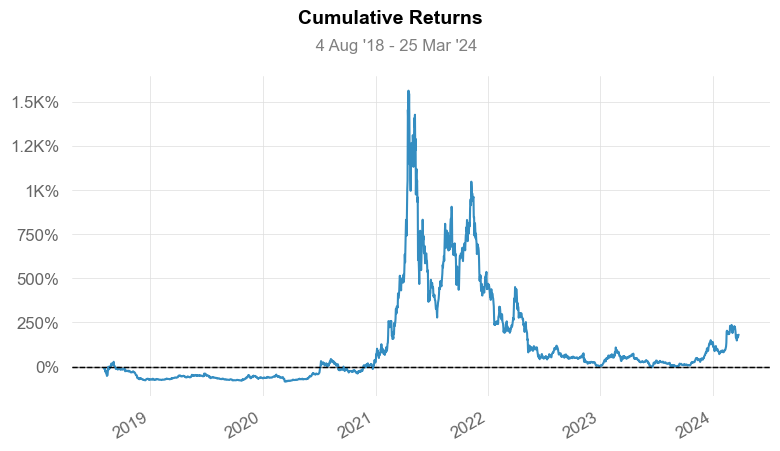

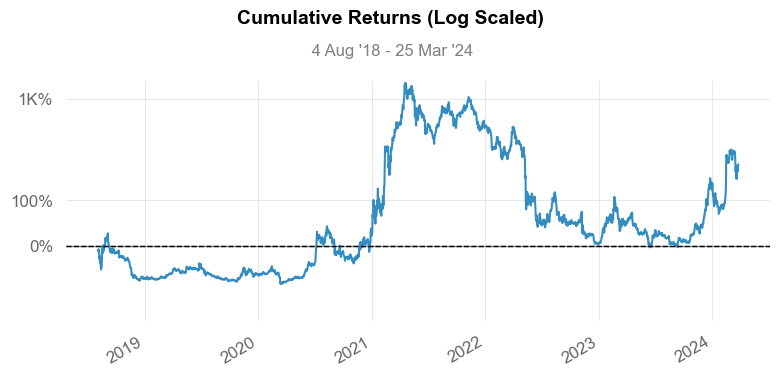

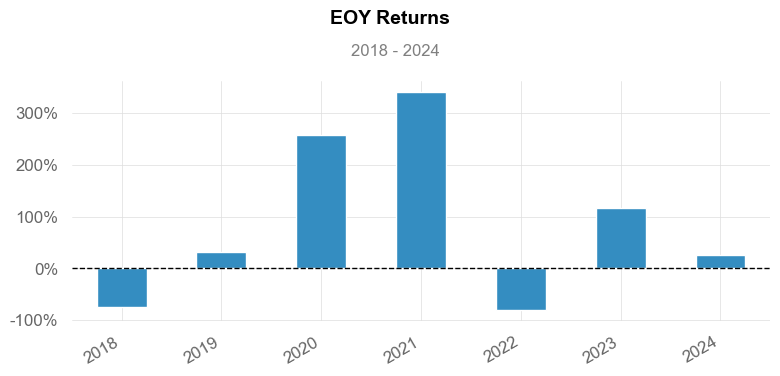

OptionError: No such keys(s): 'mode.use_inf_as_null'

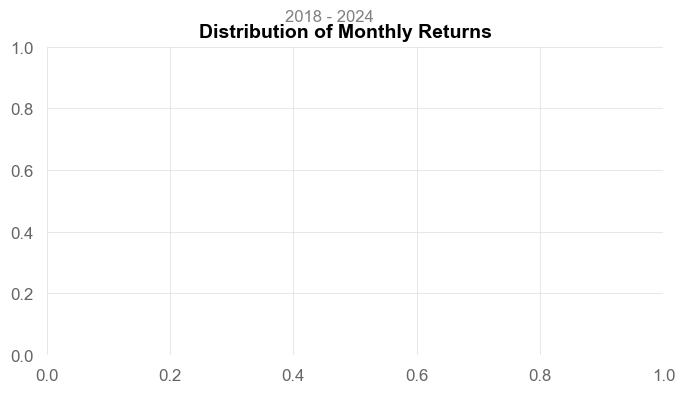

In [155]:
qs.extend_pandas()
df_compare = pd.DataFrame(data['Close'][-len( pd.Series(index)):])
df_compare['Benchmark'] = pd.Series(index).values
qs.reports.full(data['Close'].pct_change())
